In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split as tts

from tqdm import tqdm

np.random.seed(42)
random.seed(42)

In [2]:
!pip install transformers

In [3]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.38.2
Uninstalling transformers-4.38.2:
  Successfully uninstalled transformers-4.38.2
Found existing installation: accelerate 0.28.0
Uninstalling accelerate-0.28.0:
  Successfully uninstalled accelerate-0.28.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 31.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 16.1 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForPreTraining,AutoModel

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from IPython.display import clear_output

2024-04-04 09:48:01.594396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 09:48:01.594490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 09:48:01.864878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# EDA

In [5]:
df = pd.read_csv("/kaggle/input/youtube/youtube_train.csv")
df

,id,Channel,Subtitles,PublishDate,Category,ViewCount
0,0,toplesofficial,('Я миллениал и я не занимаюсь сексом так част...,2017-12-31T01:35:44-08:00,Education,3019
1,1,postnauka,"(""сервитуты это одно из прямых наследие римско...",2014-09-04T08:24:47-07:00,Science & Technology,25
2,2,NaukaPRO,('[музыка] существуют сенсоры измеряющие магни...,2023-11-23T21:00:08-08:00,Science & Technology,7
3,3,postnauka,('в наше время только ленивые не говорит о том...,2014-06-23T03:49:31-07:00,Science & Technology,5
4,4,user-rb8ux1no6j,('дорогие друзья это честный рекламный ролик н...,2020-10-09T01:30:04-07:00,Education,10
...,...,...,...,...,...,...
5844,5844,postnauka,('в освоении ребенка нового слова ключевая про...,2015-11-05T00:43:12-08:00,Science & Technology,8
5845,5845,postnauka,('опуск языка и наука которая с этим связана к...,2013-06-04T03:11:25-07:00,Science & Technology,30
5846,5846,kurilka_gutenberga,('[музыка] что я хотела сегодня вам рассказать...,2019-01-26T01:00:06-08:00,Science & Technology,3
5847,5847,postnauka,('в истории как мы уже говорили один из популя...,2016-12-26T06:55:44-08:00,Science & Technology,4


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['author'])

LabelEncoder()

In [11]:
le.classes_

array(['Akunin', 'Bulychev', 'Chehov', 'Dostoevsky', 'Gogol', 'King',
       'Pratchett', 'Remark'], dtype=object)

In [12]:
le.inverse_transform

<bound method LabelEncoder.inverse_transform of LabelEncoder()>

In [13]:
df['author'] = le.transform(df['author'])
df

,id,text,author
0,0,-Бабушка!- вскричала малютка.- Возьми меня с с...,3
1,1,"Знал ли Скрудж об этом? Разумеется, знал. Да и...",3
2,2,"-С праздником, дядя, с радостью! Дай вам Бог в...",3
3,3,Мы высказали только главную передовую мысль на...,3
4,4,"I. Отдел литературный. Повести, романы, расска...",3
...,...,...,...
1729,1729,"-Хотелось бы мне, чтоб он был здесь.\nКанторек...",7
1730,1730,Но для нас в этом-то и заключается их несостоя...,7
1731,1731,"-Как дела, Франц?- спрашивает Кропп.\nКеммерих...",7
1732,1732,"Мюллер наклоняется:\n-Мы принесли твои вещи, Ф...",7


# Визуализация

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
import plotly.express as px
fig = px.histogram(df, # возьмем данные
             x = 'author', # диаграмму будем строить по столбцу target_oil
             color = 'author', # с разбивкой по target_oil
             barmode = 'group', # разделенные столбцы располагаются рядом друг с другом
             text_auto = True, # выведем количество наблюдений в каждом столбце
             title = 'Class distribution in the data' # также добавим заголовок
             )

fig.show()

In [15]:
df['author'].unique()

array([3, 0, 1, 2, 4, 5, 6, 7])

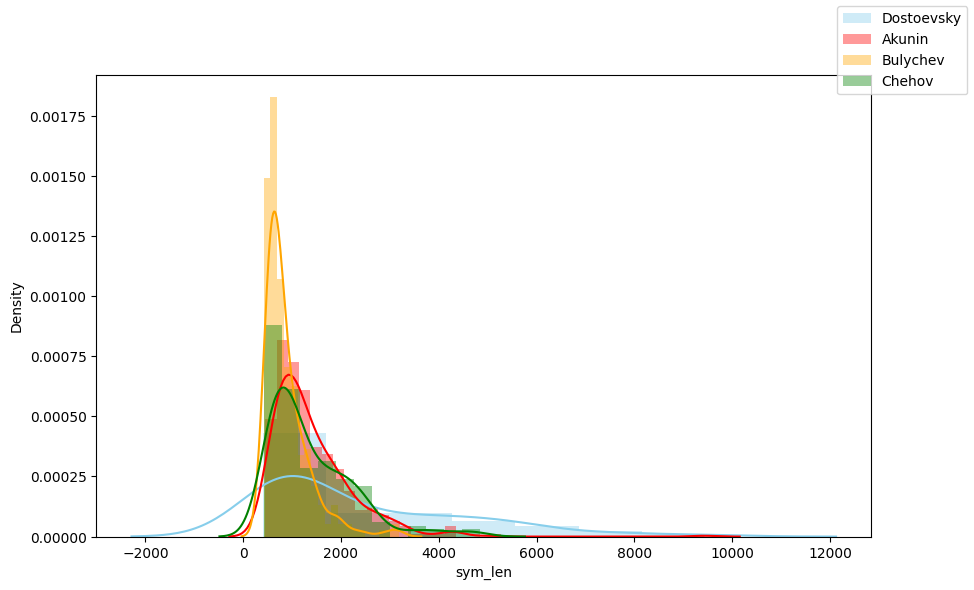

In [17]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df[df["author"] =='Dostoevsky']["sym_len"] , color="skyblue", label='Dostoevsky');
sns.distplot(df[df["author"] =='Akunin']["sym_len"] , color="red", label='Akunin');
sns.distplot(df[df["author"] =='Bulychev']["sym_len"] , color="orange", label='Bulychev');
sns.distplot(df[df["author"] =='Chehov']["sym_len"] , color="green", label= 'Chehov');
fig.legend()
plt.show()

## Tf-Idf

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
vec = TfidfVectorizer(ngram_range=(1, 3))
data_vec = vec.fit_transform(df['text_lemmas'])

KeyError: 'text_lemmas'

In [21]:
df

,id,Channel,Subtitles,PublishDate,Category,ViewCount,text_lemmas,sym_len,word_len
0,0,toplesofficial,('Я миллениал и я не занимаюсь сексом так част...,2017-12-31T01:35:44-08:00,Education,3019,миллениал заниматься секс часто хотеться милле...,8387,1021
1,1,postnauka,"(""сервитуты это одно из прямых наследие римско...",2014-09-04T08:24:47-07:00,Science & Technology,25,сервитут прямой наследие римский право совреме...,6809,802
2,2,NaukaPRO,('[музыка] существуют сенсоры измеряющие магни...,2023-11-23T21:00:08-08:00,Science & Technology,7,музыка существовать сенсор измерять магнитный ...,9326,1042
3,3,postnauka,('в наше время только ленивые не говорит о том...,2014-06-23T03:49:31-07:00,Science & Technology,5,время ленивый говорить интернет повлиять жизнь...,8762,967
4,4,user-rb8ux1no6j,('дорогие друзья это честный рекламный ролик н...,2020-10-09T01:30:04-07:00,Education,10,дорогой друг честный рекламный ролик политика ...,1696,221
...,...,...,...,...,...,...,...,...,...
5844,5844,postnauka,('в освоении ребенка нового слова ключевая про...,2015-11-05T00:43:12-08:00,Science & Technology,8,освоение ребёнок новый слово ключевой проблема...,7426,872
5845,5845,postnauka,('опуск языка и наука которая с этим связана к...,2013-06-04T03:11:25-07:00,Science & Technology,30,опуск язык наука который связать корпусный лин...,7904,960
5846,5846,kurilka_gutenberga,('[музыка] что я хотела сегодня вам рассказать...,2019-01-26T01:00:06-08:00,Science & Technology,3,музыка хотеть сегодня рассказать несколько пла...,38298,4662
5847,5847,postnauka,('в истории как мы уже говорили один из популя...,2016-12-26T06:55:44-08:00,Science & Technology,4,история говорить популярный формат аукцион гей...,7662,921


In [23]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
scal_data = scaler.fit_transform(data_vec)

n_components = 2
pca = TruncatedSVD(n_components)
pca.fit(data_vec) #scal_data

pca_data = pca.transform(data_vec)#pca.transform(scal_data)

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'ViewCount'

'''plt.figure(figsize=(10, 5))
plt.scatter(pca_data[:, 0], pca_data[:, 1], color=train.price)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Data')'''

fig = px.scatter(
    pca_data,
    x=0, y=1,
    color=df.ViewCount,
    labels=labels,
    title=f'PCA Transformed Data',
)
fig.show()

KeyError: 'Dostoevsky'

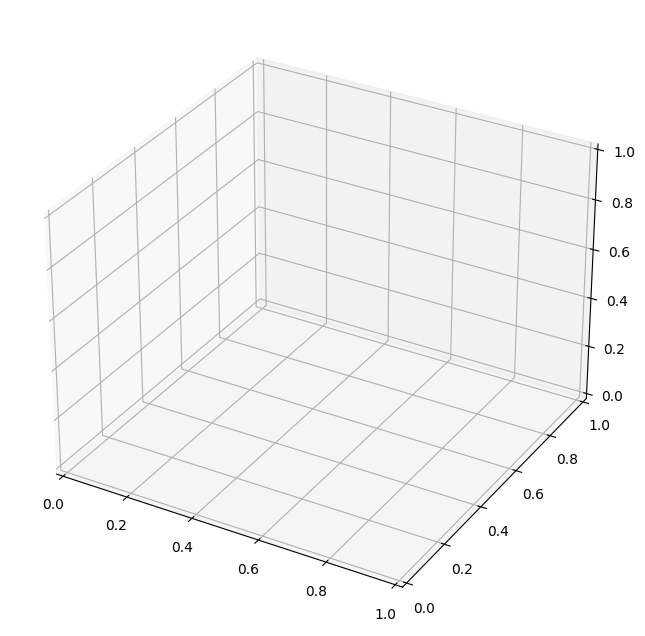

In [15]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')
for name, group in groups:
    ax.scatter(group.x, group.y, group.z, marker='o', linestyle='', label=cluster_names[name], color=cluster_colors[name])
    ax.set_aspect('auto')
    ax.tick_params(
        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(
        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
ax.view_init(elev=30, azim=75)
plt.grid(which='both')
plt.title('tf-idf + PCA representation')
ax.legend(numpoints=1)
plt.show()

## BERT encoding + CatBoost

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [32]:
model_name = "DeepPavlov/rubert-base-cased-conversational" 

deep_pavlov_classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8).to(device)
deep_pavlov_tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

In [33]:
deep_pavlov_base = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embeds(text, model, tokenizer):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings[0].to('cpu')

In [35]:
df

,id,text,author,text_lemmas
0,0,-Бабушка!- вскричала малютка.- Возьми меня с с...,3,бабушка вскричать малютка взять знать уйти пог...
1,1,"Знал ли Скрудж об этом? Разумеется, знал. Да и...",3,знать скрудж разумеется знать мочь иначе скруд...
2,2,"-С праздником, дядя, с радостью! Дай вам Бог в...",3,праздник дядя радость дать весь благо земной р...
3,3,Мы высказали только главную передовую мысль на...,3,высказать главный передовой мысль журнал намек...
4,4,"I. Отдел литературный. Повести, романы, расска...",3,отдел литературный повесть роман рассказ мемуа...
...,...,...,...,...
1729,1729,"-Хотелось бы мне, чтоб он был здесь.\nКанторек...",7,хотеться канторека классный наставник строгий ...
1730,1730,Но для нас в этом-то и заключается их несостоя...,7,заключаться несостоятельность восемнадцатилетн...
1731,1731,"-Как дела, Франц?- спрашивает Кропп.\nКеммерих...",7,дело франц спрашивать кроппа кеммерих опускать...
1732,1732,"Мюллер наклоняется:\n-Мы принесли твои вещи, Ф...",7,мюллер наклоняться принести твой вещь франц ке...


In [37]:
df['embedding'] = df['text'].apply(get_embeds, model=deep_pavlov_base, tokenizer=deep_pavlov_tokenizer)
df

,id,text,author,text_lemmas,embedding
0,0,-Бабушка!- вскричала малютка.- Возьми меня с с...,3,бабушка вскричать малютка взять знать уйти пог...,"[tensor(0.0217), tensor(-0.0198), tensor(-0.01..."
1,1,"Знал ли Скрудж об этом? Разумеется, знал. Да и...",3,знать скрудж разумеется знать мочь иначе скруд...,"[tensor(0.0166), tensor(-0.0101), tensor(0.036..."
2,2,"-С праздником, дядя, с радостью! Дай вам Бог в...",3,праздник дядя радость дать весь благо земной р...,"[tensor(-0.0107), tensor(-0.0186), tensor(0.00..."
3,3,Мы высказали только главную передовую мысль на...,3,высказать главный передовой мысль журнал намек...,"[tensor(-0.0254), tensor(-0.0041), tensor(0.03..."
4,4,"I. Отдел литературный. Повести, романы, расска...",3,отдел литературный повесть роман рассказ мемуа...,"[tensor(-0.0215), tensor(-0.0313), tensor(-0.0..."
...,...,...,...,...,...
1729,1729,"-Хотелось бы мне, чтоб он был здесь.\nКанторек...",7,хотеться канторека классный наставник строгий ...,"[tensor(-0.0136), tensor(-0.0294), tensor(0.02..."
1730,1730,Но для нас в этом-то и заключается их несостоя...,7,заключаться несостоятельность восемнадцатилетн...,"[tensor(-0.0040), tensor(-0.0234), tensor(-0.0..."
1731,1731,"-Как дела, Франц?- спрашивает Кропп.\nКеммерих...",7,дело франц спрашивать кроппа кеммерих опускать...,"[tensor(-0.0128), tensor(-0.0153), tensor(-0.0..."
1732,1732,"Мюллер наклоняется:\n-Мы принесли твои вещи, Ф...",7,мюллер наклоняться принести твой вещь франц ке...,"[tensor(-0.0158), tensor(-0.0262), tensor(-0.0..."


In [72]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        eval_metric='TotalF1',#"Accuracy",
        iterations=5000,
        learning_rate=0.05,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )

In [73]:
X = df[['text','text_lemmas', 'embedding']]
y = df['author']
X_train, X_test, y_train, y_test = tts(X, y,random_state=42, train_size=0.7, shuffle=True)

In [74]:
df

,id,text,author,text_lemmas,embedding
0,0,-Бабушка!- вскричала малютка.- Возьми меня с с...,3,бабушка вскричать малютка взять знать уйти пог...,"[tensor(0.0217), tensor(-0.0198), tensor(-0.01..."
1,1,"Знал ли Скрудж об этом? Разумеется, знал. Да и...",3,знать скрудж разумеется знать мочь иначе скруд...,"[tensor(0.0166), tensor(-0.0101), tensor(0.036..."
2,2,"-С праздником, дядя, с радостью! Дай вам Бог в...",3,праздник дядя радость дать весь благо земной р...,"[tensor(-0.0107), tensor(-0.0186), tensor(0.00..."
3,3,Мы высказали только главную передовую мысль на...,3,высказать главный передовой мысль журнал намек...,"[tensor(-0.0254), tensor(-0.0041), tensor(0.03..."
4,4,"I. Отдел литературный. Повести, романы, расска...",3,отдел литературный повесть роман рассказ мемуа...,"[tensor(-0.0215), tensor(-0.0313), tensor(-0.0..."
...,...,...,...,...,...
1729,1729,"-Хотелось бы мне, чтоб он был здесь.\nКанторек...",7,хотеться канторека классный наставник строгий ...,"[tensor(-0.0136), tensor(-0.0294), tensor(0.02..."
1730,1730,Но для нас в этом-то и заключается их несостоя...,7,заключаться несостоятельность восемнадцатилетн...,"[tensor(-0.0040), tensor(-0.0234), tensor(-0.0..."
1731,1731,"-Как дела, Франц?- спрашивает Кропп.\nКеммерих...",7,дело франц спрашивать кроппа кеммерих опускать...,"[tensor(-0.0128), tensor(-0.0153), tensor(-0.0..."
1732,1732,"Мюллер наклоняется:\n-Мы принесли твои вещи, Ф...",7,мюллер наклоняться принести твой вещь франц ке...,"[tensor(-0.0158), tensor(-0.0262), tensor(-0.0..."


In [75]:
embedding_features = ['embedding']

train_pool = Pool(
    X_train, y_train,
    text_features=['text','text_lemmas'],
    embedding_features=embedding_features,
)


val_pool = Pool(
    X_test, y_test,
    text_features=['text','text_lemmas'],
    embedding_features=embedding_features,
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

cat_boost = fit_model(train_pool, val_pool)

Train dataset shape: (1213, 3)

0:	learn: 0.7655800	test: 0.8154579	best: 0.8154579 (0)	total: 38.3ms	remaining: 3m 11s
500:	learn: 0.9181606	test: 0.8974794	best: 0.8993008 (204)	total: 10.2s	remaining: 1m 31s
1000:	learn: 0.9669450	test: 0.8990728	best: 0.9008221 (959)	total: 20.2s	remaining: 1m 20s
1500:	learn: 0.9892732	test: 0.9005780	best: 0.9008221 (959)	total: 31.1s	remaining: 1m 12s
2000:	learn: 0.9950537	test: 0.9008221	best: 0.9008221 (959)	total: 40.9s	remaining: 1m 1s
2500:	learn: 0.9983516	test: 0.9055411	best: 0.9055411 (2462)	total: 49.9s	remaining: 49.8s
3000:	learn: 1.0000000	test: 0.9032731	best: 0.9055411 (2462)	total: 58.9s	remaining: 39.3s
3500:	learn: 1.0000000	test: 0.8968522	best: 0.9055411 (2462)	total: 1m 8s	remaining: 29.1s
4000:	learn: 1.0000000	test: 0.8968522	best: 0.9055411 (2462)	total: 1m 16s	remaining: 19.2s
4500:	learn: 1.0000000	test: 0.8968522	best: 0.9055411 (2462)	total: 1m 24s	remaining: 9.42s
4999:	learn: 1.0000000	test: 0.8968522	best: 0.90554

Accuracy: 0.9097888675623801
F1: 0.8372473758451805


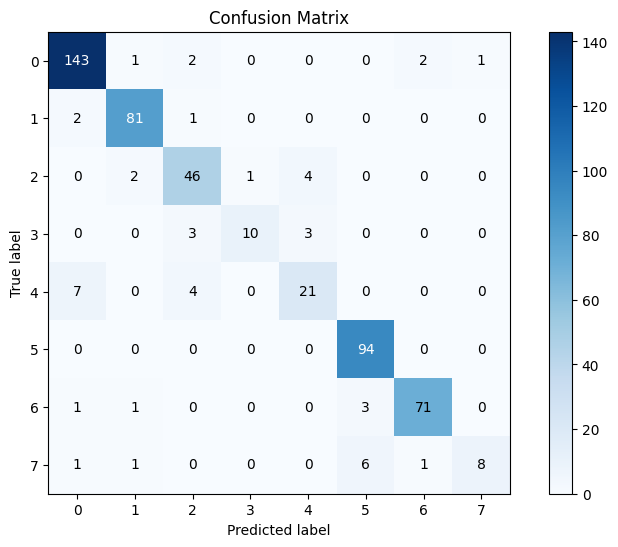

In [76]:
y_pred = cat_boost.predict(val_pool)
print('Accuracy:',accuracy_score(y_pred, y_test))
print('F1:',f1_score(y_pred, y_test, average='macro'))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False, figsize=(10,6))
plt.show()

## Tune NN + CatBoost

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model_name = "DeepPavlov/rubert-base-cased-conversational" #"DeepPavlov/rubert-base-cased"

classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

In [18]:
X_train, X_val, y_train, y_val = tts(df['text_f'], df['author'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [19]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [21]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
            'accuracy'      :acc,
            'f1 macro'      : f1
            }

In [22]:
training_args = TrainingArguments(
    run_name = 'rubert-base-tune-1',
    output_dir='./results',
    learning_rate=5e-5,
    max_steps = 600,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    save_total_limit=4,
    load_best_model_at_end=True,
    logging_steps=100,
    save_steps=100,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1 macro
100,1.435700,0.676334,0.785029,0.537121
200,0.391800,0.394674,0.863724,0.744160
300,0.150600,0.591607,0.844530,0.756330
400,0.102900,0.367277,0.898273,0.816587
500,0.075500,0.486600,0.896353,0.836202
600,0.048700,0.588892,0.898273,0.823030


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=600, training_loss=0.36751357396443685, metrics={'train_runtime': 1179.2596, 'train_samples_per_second': 16.281, 'train_steps_per_second': 0.509, 'total_flos': 5040163772375040.0, 'train_loss': 0.36751357396443685, 'epoch': 15.79})

In [ ]:
tokenizer.save_pretrained("tokenizer_rubert")
classifier.save_pretrained("model_rubert")

In [31]:
test_pred = trainer.predict(valid_dataset)
labels = test_pred[0].argmax(-1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
test_pred[-2]

Accuracy: 0.8982725527831094
F1: 0.8165873473583749


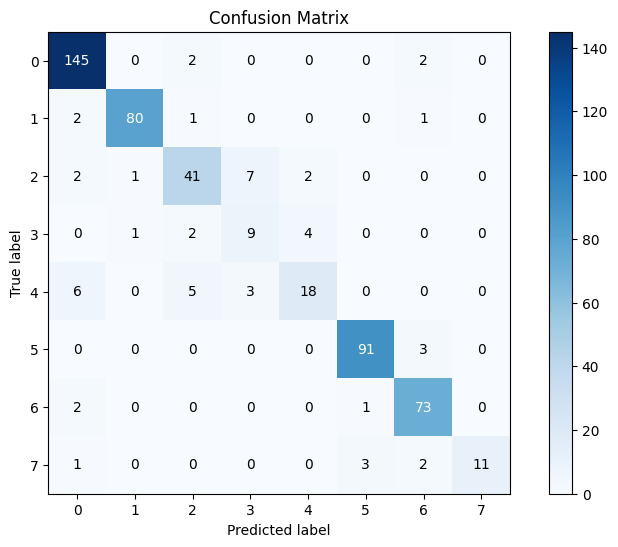

In [33]:
print('Accuracy:',accuracy_score(test_pred[-2], labels))
print('F1:',f1_score(test_pred[-2], labels, average='macro'))
skplt.metrics.plot_confusion_matrix(test_pred[-2], labels, normalize=False, figsize=(10,6))
plt.show()

# NN

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
model_name = "papluca/xlm-roberta-base-language-detection"#"DeepPavlov/rubert-base-cased"  # seara/rubert-tiny2-russian-sentiment # DeepPavlov/rubert-base-cased-conversational
#papluca/xlm-roberta-base-language-detection
classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8,ignore_mismatched_sizes=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at papluca/xlm-roberta-base-language-detection and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([20, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [25]:
df['text_f'] = df.apply(lambda x: " [CLS] " + x.text.replace(".", " [SEP] "), axis=1)
df.sample(10)

,id,text,author,text_f
511,511,Ставить на себе крест в двадцать лет всякому г...,0,[CLS] Ставить на себе крест в двадцать лет вс...
51,51,"Мороз увеличился, и вверху так сделалось холод...",3,"[CLS] Мороз увеличился, и вверху так сделалос..."
1171,1171,-Вот что пока происходило в вашей взрослой жиз...,5,[CLS] -Вот что пока происходило в вашей взрос...
768,768,"-Слушай, ты перегрелся?- Олег вышел на берег, ...",1,"[CLS] -Слушай, ты перегрелся?- Олег вышел на ..."
557,557,"Сашка стал помогать мне сложить ширму, а тут п...",1,"[CLS] Сашка стал помогать мне сложить ширму, ..."
764,764,Тысячу лет назад лодка могла подойти к острову...,1,[CLS] Тысячу лет назад лодка могла подойти к ...
1200,1200,-Ну…\nВеттер зажег спичку и взглянул на Фарнхэ...,5,[CLS] -Ну…\nВеттер зажег спичку и взглянул на...
192,192,-Вы к кому?- с потрескиванием спрашивает щиток...,0,[CLS] -Вы к кому?- с потрескиванием спрашивае...
1539,1539,"Стену не обманешь, рассуждал он. Может, получи...",6,"[CLS] Стену не обманешь, рассуждал он [SEP] ..."
849,849,"Евгений Сергеевич Дорн, врач.\nСемен Семенович...",2,"[CLS] Евгений Сергеевич Дорн, врач [SEP] \nСе..."


In [26]:
X_train, X_val, y_train, y_val = tts(df['text_f'], df['author'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [27]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [28]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [29]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
            'accuracy'      :acc,
            'f1 macro'      : f1
            }

In [30]:
training_args = TrainingArguments(
    run_name = 'roberta-base',
    output_dir='./results',
    learning_rate=5e-5,
    max_steps = 1000,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    save_total_limit=4,
    load_best_model_at_end=True,
    logging_steps=100,
    save_steps=100,
    fp16=True,
    evaluation_strategy="steps")

trainer = Trainer(
    model=classifier.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

In [31]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1 macro
100,1.665900,0.933035,0.719770,0.466413
200,0.694400,0.798387,0.744722,0.518623
300,0.384200,0.600648,0.819578,0.707692
400,0.200500,0.514240,0.869482,0.800054
500,0.135900,0.581567,0.840691,0.774442
600,0.109700,0.542298,0.875240,0.778837
700,0.085200,0.656681,0.854127,0.791811
800,0.057600,0.636386,0.880998,0.816041
900,0.055400,0.732910,0.871401,0.805498
1000,0.041600,0.740467,0.886756,0.824062


TrainOutput(global_step=1000, training_loss=0.3430433921813965, metrics={'train_runtime': 2043.043, 'train_samples_per_second': 15.663, 'train_steps_per_second': 0.489, 'total_flos': 8399483578269696.0, 'train_loss': 0.3430433921813965, 'epoch': 26.32})

In [ ]:
#tokenizer.save_pretrained("tokenizer_rubert")
#classifier.save_pretrained("model_rubert")

In [34]:
test_pred = trainer.predict(valid_dataset)
labels = test_pred[0].argmax(-1)

In [41]:
!pip install plot-confusion-matrix

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('Accuracy:',accuracy_score(test_pred[-2], labels))
print('F1:',f1_score(test_pred[-2], labels, average='macro'))
cm = confusion_matrix(labels, test_pred[-2], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

Accuracy: 0.8694817658349329
F1: 0.800054498084279


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
print('Accuracy :',accuracy_score(labels,y_val))
print('F1_macro:', f1_score(labels,y_val, average='macro'))
print('F1_micro:', f1_score(labels,y_val, average='micro'))
print('Precision:', precision_score(labels,y_val,average='micro'))
print('Recall:', precision_score(labels,y_val, average='micro'))

In [ ]:
le.inverse_transform

## BERT + NN Regressor

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
model_name = "DeepPavlov/rubert-base-cased" 
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

In [17]:
df

,id,Channel,Subtitles,PublishDate,Category,ViewCount,text_f
0,0,toplesofficial,('Я миллениал и я не занимаюсь сексом так част...,2017-12-31T01:35:44-08:00,Education,3019,[CLS] ('Я миллениал и я не занимаюсь сексом т...
1,1,postnauka,"(""сервитуты это одно из прямых наследие римско...",2014-09-04T08:24:47-07:00,Science & Technology,25,"[CLS] (""сервитуты это одно из прямых наследие..."
2,2,NaukaPRO,('[музыка] существуют сенсоры измеряющие магни...,2023-11-23T21:00:08-08:00,Science & Technology,7,[CLS] ('[музыка] существуют сенсоры измеряющи...
3,3,postnauka,('в наше время только ленивые не говорит о том...,2014-06-23T03:49:31-07:00,Science & Technology,5,[CLS] ('в наше время только ленивые не говори...
4,4,user-rb8ux1no6j,('дорогие друзья это честный рекламный ролик н...,2020-10-09T01:30:04-07:00,Education,10,[CLS] ('дорогие друзья это честный рекламный ...
...,...,...,...,...,...,...,...
5844,5844,postnauka,('в освоении ребенка нового слова ключевая про...,2015-11-05T00:43:12-08:00,Science & Technology,8,[CLS] ('в освоении ребенка нового слова ключе...
5845,5845,postnauka,('опуск языка и наука которая с этим связана к...,2013-06-04T03:11:25-07:00,Science & Technology,30,[CLS] ('опуск языка и наука которая с этим св...
5846,5846,kurilka_gutenberga,('[музыка] что я хотела сегодня вам рассказать...,2019-01-26T01:00:06-08:00,Science & Technology,3,[CLS] ('[музыка] что я хотела сегодня вам рас...
5847,5847,postnauka,('в истории как мы уже говорили один из популя...,2016-12-26T06:55:44-08:00,Science & Technology,4,[CLS] ('в истории как мы уже говорили один из...


In [18]:
df['text_f'] = df.apply(lambda x: " [CLS] " + x.Subtitles.replace(".", " [SEP] "), axis=1)
df.sample(10)

,id,Channel,Subtitles,PublishDate,Category,ViewCount,text_f
4289,4289,postnauka,('наш организм довольно богато снабжен различн...,2017-04-21T07:16:57-07:00,Science & Technology,62,[CLS] ('наш организм довольно богато снабжен ...
2186,2186,RedRoomLIMB/videos,('привет я егор и это link где мы говорим о ме...,2015-04-18T02:02:26-07:00,Education,278,[CLS] ('привет я егор и это link где мы говор...
2119,2119,postnauka,"(""не тут их металл эти нет invid ну просто тот...",2018-11-16T10:43:53-08:00,Science & Technology,7,"[CLS] (""не тут их металл эти нет invid ну про..."
613,613,postnauka,('Кто такой эксперт? В социологии есть несколь...,2019-01-16T00:45:56-08:00,Science & Technology,12,[CLS] ('Кто такой эксперт? В социологии есть ...
3552,3552,kurilka_gutenberga,('[музыка] добрый вечер спасибо что вы пришли ...,2020-10-08T01:00:05-07:00,Science & Technology,2,[CLS] ('[музыка] добрый вечер спасибо что вы ...
2323,2323,ArturSharifov,"(""в 2009 году 50 восьмилетний американец кларе...",2021-09-17T08:05:10-07:00,Science & Technology,665,"[CLS] (""в 2009 году 50 восьмилетний американе..."
119,119,UtopiaShow,('12 апреля 1961 года человек первый раз полет...,2017-04-12T02:26:14-07:00,Science & Technology,1700,[CLS] ('12 апреля 1961 года человек первый ра...
405,405,RedRoomLIMB/videos,('говоря об античности в первую очередь вспоми...,2021-03-22T11:05:20-07:00,Education,323,[CLS] ('говоря об античности в первую очередь...
4364,4364,AntropogenezRu,('[музыка] друзья привет мы зимой день в египт...,2021-02-18T07:06:58-08:00,Travel & Events,33,[CLS] ('[музыка] друзья привет мы зимой день ...
4667,4667,AntropogenezRu,('мы находимся в иерусалиме привет всем кто ме...,2019-04-02T01:34:49-07:00,Science & Technology,20,[CLS] ('мы находимся в иерусалиме привет всем...


In [19]:
X_train, X_val, y_train, y_val = tts(df['text_f'], df['ViewCount'], random_state=42, test_size=0.3, shuffle=True)
X_train = X_train.tolist()
X_val = X_val.tolist()
y_train = y_train.tolist()
y_val = y_val.tolist()

train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [38]:
class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [39]:
train_dataset = GroupsDataset(train_encodings, y_train)
valid_dataset = GroupsDataset(val_encodings, y_val)

In [58]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class BertForTextRegression(nn.Module):
    def __init__(self, bert_model_path):
        super().__init__()
        self.bert_model = BertModel.from_pretrained(bert_model_path)
        self.dropout = nn.Dropout(0.1)
        self.regressor = nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self. dropout(pooled_output)
        logits = self.regressor(pooled_output)
        return logits

In [59]:
model = BertForTextRegression(bert_model_path = "DeepPavlov/rubert-base-cased")
model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForTextRegression(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [60]:
!pip install wandb -qU
import wandb
import matplotlib.pyplot as plt
import copy

wandb.login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [61]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(
            train_dataset,
            batch_size = batch_size
        )

val_loader = DataLoader(
            valid_dataset,
            batch_size = batch_size
        )

In [62]:
lr = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss() #criterion = nn.CrossEntropyLoss()

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 137.06 MiB is free. Process 3021 has 14.61 GiB memory in use. Of the allocated memory 14.05 GiB is allocated by PyTorch, and 436.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

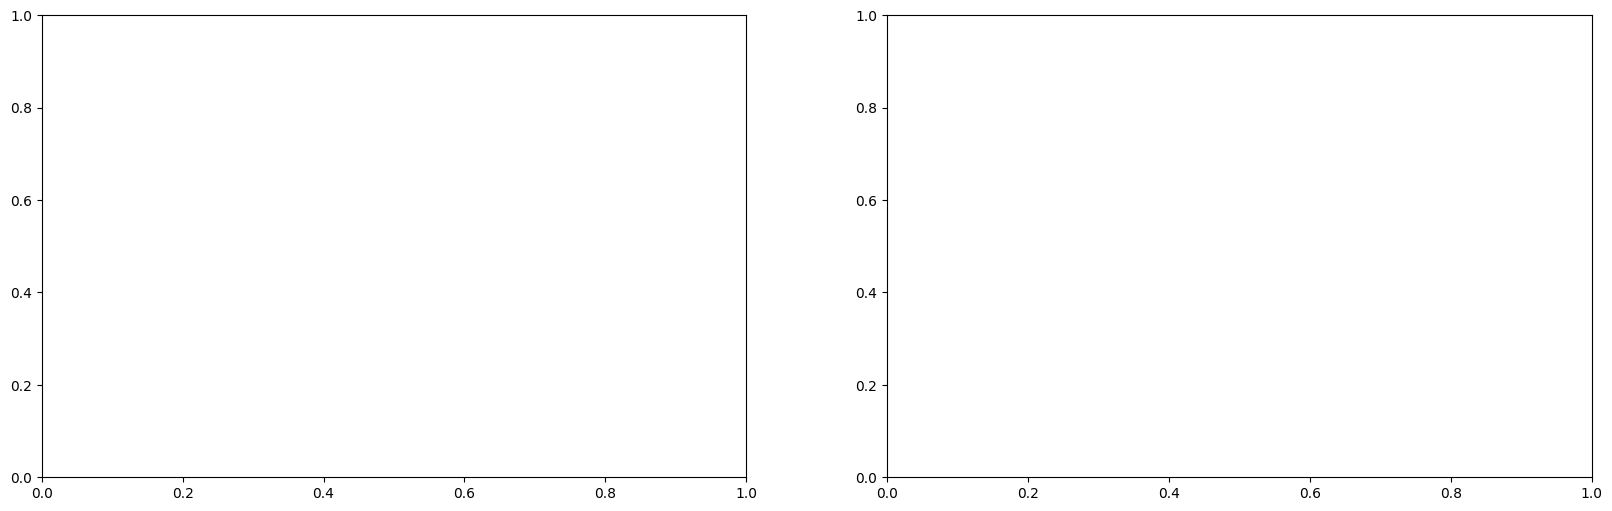

In [63]:
epochs = 5

MAE_history = []
val_MAE_history = []
loss_history = []
val_loss_history = []

best_val_loss = float('inf')
best_model = None

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

wandb.init(
    project="BERT-Regressor",
    name = "BERT+NN",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": lr
        })

# Copy your config
config = wandb.config

MAE = nn.L1Loss()
for epoch in range(config.epochs):
    
    for batch in train_loader:
        
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        label = batch['labels'].float().to(device)
        
        
        output = model(b_input_ids,
                     attention_mask=b_input_mask)

        epoch_loss = criterion(output, label)

        optimizer.zero_grad()
        epoch_loss.backward()
        optimizer.step()
        epoch_mae = MAE(output,label) #((output.argmax(dim=1) == label).float().mean())
        
    MAE_history.append(epoch_mae.detach().cpu().numpy())
    loss_history.append(epoch_loss.detach().cpu().numpy())
    metrics = {"train/train_loss": epoch_loss,
                "train/MAE": epoch_mae}


    with torch.no_grad():
        
        for batch in train_loader:

            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            label = batch['labels'].float().to(device)
        
        
            val_output = model(b_input_ids, 
                     attention_mask=b_input_mask)
            
            epoch_val_loss = criterion(val_output,label)
            epoch_val_mae = MAE(val_output,label) #((val_output.argmax(dim=1) == label).float().mean())
        print(f'Epoch [{epoch+1}/{epochs}], train Loss: {epoch_loss:.4f}, train MAE: {epoch_mae:.4f},  val Loss: {epoch_val_loss:.4f}, val MAE: {epoch_val_mae:.4f}')
        val_MAE_history.append(epoch_val_mae.detach().cpu().numpy())
        val_loss_history.append(epoch_val_loss.detach().cpu().numpy())

        val_metrics = {"val/val_loss": epoch_val_loss,
                       "val/val_MAE": epoch_val_accuracy}
        wandb.log({**metrics, **val_metrics})

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), 'best_model.pt')
            print('best model saved!')


plt.plot(accuracy_history, label='accuracy')
plt.plot(val_accuracy_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# predict

In [57]:
test = pd.read_csv("/kaggle/input/nlp-prof/test_texts.csv")
test

,id,text
0,1734,"Идти ему было немного; он даже знал, сколько ш..."
1,1735,"-Твой дедушка был немножко пиратом, а как увер..."
2,1736,"У меня был немецкий паспорт, годный еще на цел..."
3,1737,"-Ну как знаете,- сказал я и сделал вид, будто ..."
4,1738,Я отмахнулся.\n-На шестнадцать и пятьдесят одн...
...,...,...
325,2059,"-А правда,- сказал Маратик,- давай завтра еще ..."
326,2060,"Иванов (графу). Ax, не зуди ты, зуда! (Львову...."
327,2061,"Существо, которое называли Игорем, захлопнуло ..."
328,2062,"-Ма, вы с дядей Флавием дали мне образование, ..."


In [ ]:
arr_1 = []
for i in list(test['PublishDate']):
    arr_1.append(i.split('T')[0])
test['PublishDate']= pd.to_datetime(arr_1)
test['day_space'] = (pd.to_datetime('today').normalize() - test['PublishDate']).dt.days
test

In [58]:
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, test['text']), total=len(test)))

test['text_lemmas'] = lemmas
test['embedding'] = test['text'].apply(get_embeds, model=deep_pavlov_base, tokenizer=deep_pavlov_tokenizer)
test

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,id,text,text_lemmas,embedding
0,1734,"Идти ему было немного; он даже знал, сколько ш...",идти немного знать сколько ворота ровно семьсо...,"[tensor(-0.0069), tensor(-0.0317), tensor(0.00..."
1,1735,"-Твой дедушка был немножко пиратом, а как увер...",твой дедушка немножко пират уверовать струхнут...,"[tensor(0.0003), tensor(-0.0321), tensor(0.038..."
2,1736,"У меня был немецкий паспорт, годный еще на цел...",немецкий паспорт годный целый четыре месяц под...,"[tensor(0.0027), tensor(-0.0195), tensor(0.029..."
3,1737,"-Ну как знаете,- сказал я и сделал вид, будто ...",знать сказать сделать собираться поставить ста...,"[tensor(0.0140), tensor(-0.0157), tensor(-0.01..."
4,1738,Я отмахнулся.\n-На шестнадцать и пятьдесят одн...,отмахнуться шестнадцать пятьдесят одновременно...,"[tensor(0.0131), tensor(-0.0427), tensor(0.000..."
...,...,...,...,...
325,2059,"-А правда,- сказал Маратик,- давай завтра еще ...",правда сказать маратик давать завтра поджечь с...,"[tensor(0.0091), tensor(-0.0351), tensor(0.037..."
326,2060,"Иванов (графу). Ax, не зуди ты, зуда! (Львову....",иванов графа зудеть львов ехать крым нужный ср...,"[tensor(-0.0015), tensor(-0.0235), tensor(-0.0..."
327,2061,"Существо, которое называли Игорем, захлопнуло ...",существо который называть игорь захлопнуть две...,"[tensor(0.0215), tensor(-0.0473), tensor(-0.05..."
328,2062,"-Ма, вы с дядей Флавием дали мне образование, ...",дядя флавий дать образование знать цифра арифм...,"[tensor(0.0115), tensor(-0.0248), tensor(0.022..."


In [59]:
test_pool = Pool(
    test[['text','text_lemmas','embedding']],
    text_features=['text','text_lemmas','embedding'],
    embedding_features=embedding_features,
)
y_pred = cat_boost.predict(test_pool)

test["author"] = y_pred.flatten()
test

,id,text,text_lemmas,embedding,author
0,1734,"Идти ему было немного; он даже знал, сколько ш...",идти немного знать сколько ворота ровно семьсо...,"[tensor(-0.0069), tensor(-0.0317), tensor(0.00...",3
1,1735,"-Твой дедушка был немножко пиратом, а как увер...",твой дедушка немножко пират уверовать струхнут...,"[tensor(0.0003), tensor(-0.0321), tensor(0.038...",6
2,1736,"У меня был немецкий паспорт, годный еще на цел...",немецкий паспорт годный целый четыре месяц под...,"[tensor(0.0027), tensor(-0.0195), tensor(0.029...",0
3,1737,"-Ну как знаете,- сказал я и сделал вид, будто ...",знать сказать сделать собираться поставить ста...,"[tensor(0.0140), tensor(-0.0157), tensor(-0.01...",5
4,1738,Я отмахнулся.\n-На шестнадцать и пятьдесят одн...,отмахнуться шестнадцать пятьдесят одновременно...,"[tensor(0.0131), tensor(-0.0427), tensor(0.000...",1
...,...,...,...,...,...
325,2059,"-А правда,- сказал Маратик,- давай завтра еще ...",правда сказать маратик давать завтра поджечь с...,"[tensor(0.0091), tensor(-0.0351), tensor(0.037...",1
326,2060,"Иванов (графу). Ax, не зуди ты, зуда! (Львову....",иванов графа зудеть львов ехать крым нужный ср...,"[tensor(-0.0015), tensor(-0.0235), tensor(-0.0...",2
327,2061,"Существо, которое называли Игорем, захлопнуло ...",существо который называть игорь захлопнуть две...,"[tensor(0.0215), tensor(-0.0473), tensor(-0.05...",6
328,2062,"-Ма, вы с дядей Флавием дали мне образование, ...",дядя флавий дать образование знать цифра арифм...,"[tensor(0.0115), tensor(-0.0248), tensor(0.022...",1


In [60]:
test["author"] = le.inverse_transform(test["author"])
test

,id,text,text_lemmas,embedding,author
0,1734,"Идти ему было немного; он даже знал, сколько ш...",идти немного знать сколько ворота ровно семьсо...,"[tensor(-0.0069), tensor(-0.0317), tensor(0.00...",Dostoevsky
1,1735,"-Твой дедушка был немножко пиратом, а как увер...",твой дедушка немножко пират уверовать струхнут...,"[tensor(0.0003), tensor(-0.0321), tensor(0.038...",Pratchett
2,1736,"У меня был немецкий паспорт, годный еще на цел...",немецкий паспорт годный целый четыре месяц под...,"[tensor(0.0027), tensor(-0.0195), tensor(0.029...",Akunin
3,1737,"-Ну как знаете,- сказал я и сделал вид, будто ...",знать сказать сделать собираться поставить ста...,"[tensor(0.0140), tensor(-0.0157), tensor(-0.01...",King
4,1738,Я отмахнулся.\n-На шестнадцать и пятьдесят одн...,отмахнуться шестнадцать пятьдесят одновременно...,"[tensor(0.0131), tensor(-0.0427), tensor(0.000...",Bulychev
...,...,...,...,...,...
325,2059,"-А правда,- сказал Маратик,- давай завтра еще ...",правда сказать маратик давать завтра поджечь с...,"[tensor(0.0091), tensor(-0.0351), tensor(0.037...",Bulychev
326,2060,"Иванов (графу). Ax, не зуди ты, зуда! (Львову....",иванов графа зудеть львов ехать крым нужный ср...,"[tensor(-0.0015), tensor(-0.0235), tensor(-0.0...",Chehov
327,2061,"Существо, которое называли Игорем, захлопнуло ...",существо который называть игорь захлопнуть две...,"[tensor(0.0215), tensor(-0.0473), tensor(-0.05...",Pratchett
328,2062,"-Ма, вы с дядей Флавием дали мне образование, ...",дядя флавий дать образование знать цифра арифм...,"[tensor(0.0115), tensor(-0.0248), tensor(0.022...",Bulychev


In [61]:
test[['id','author']].to_csv("CB_BERT_5000.csv", index = False)

In [40]:
data_t = pd.read_csv("/kaggle/input/nlp-prof/sample_submission.csv")
data_t

,id,author
0,1734,Dostoevsky
1,1735,Dostoevsky
2,1736,Dostoevsky
3,1737,Dostoevsky
4,1738,Dostoevsky
...,...,...
325,2059,Dostoevsky
326,2060,Dostoevsky
327,2061,Dostoevsky
328,2062,Dostoevsky
